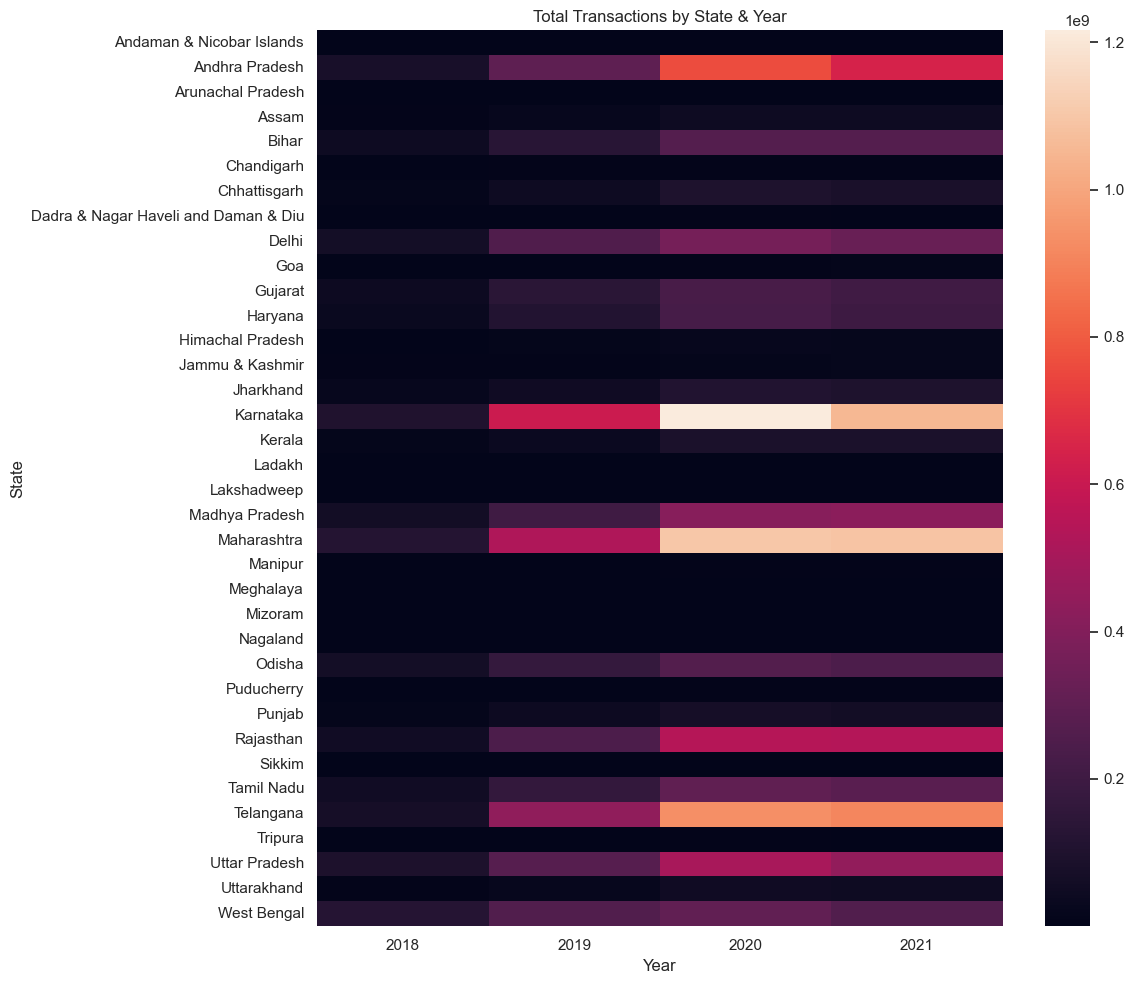

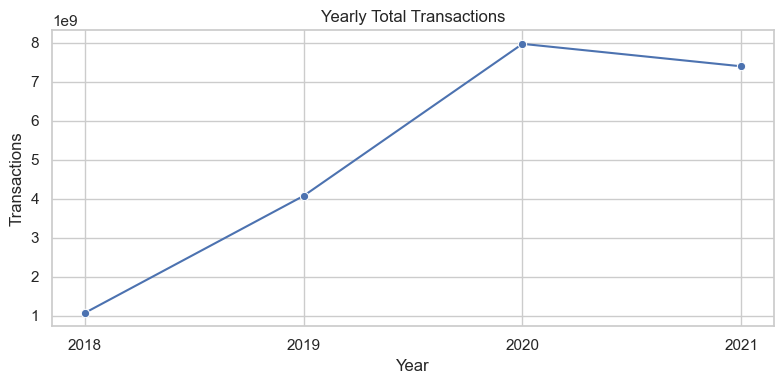

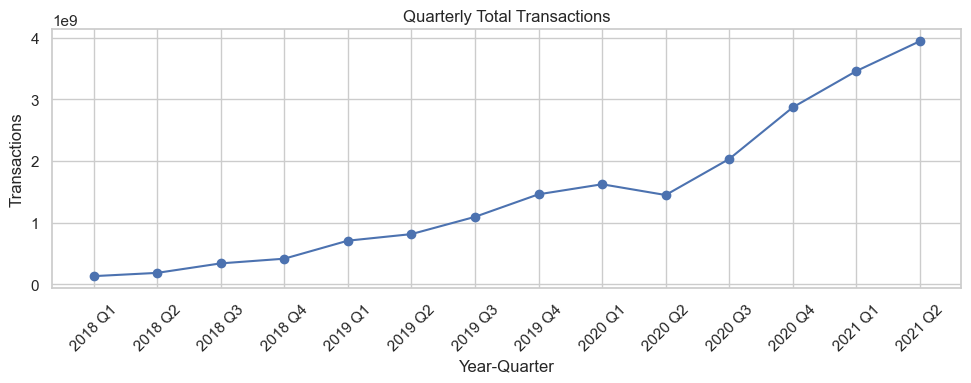

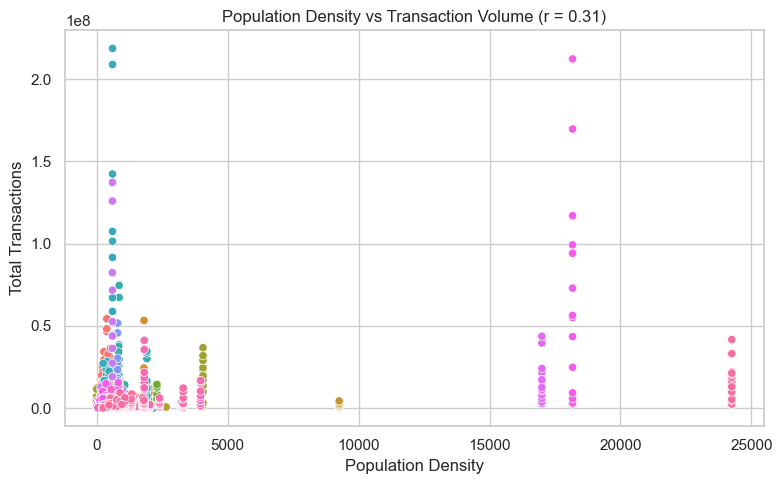

Correlation (Density vs Transactions): 0.308


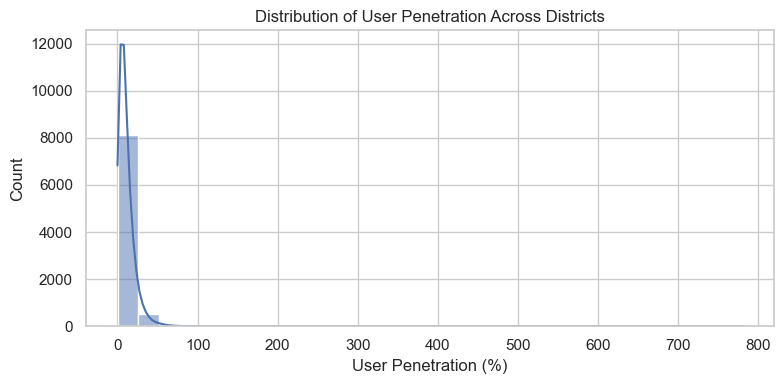

--- Hypothesis Test Results ---
H1_density_vs_transactions:
  test: Pearson correlation (Density vs Transactions)
  r: 0.30770410875592846
  p_value: 3.826389316630344e-192
  n: 8792
  H0: No linear correlation between density and transactions
  H1: Non-zero linear correlation between density and transactions
  conclusion: Reject H0 at α=0.05
H2_atv_high_vs_low_states:
  test: Independent t-test (ATV: high-user vs low-user states)
  t_statistic: -14.758211952793678
  p_value: 1.0826820962820193e-27
  n_top: 70
  n_bottom: 70
  H0: Mean ATV is equal for high-user and low-user states
  H1: Mean ATV differs between high-user and low-user states
  conclusion: Reject H0 at α=0.05
H3_increase_in_transactions_over_years:
  test: One-sided t-test (Yearly transactions: earliest vs latest year)
  note: This test should ideally be run on state-level yearly data, not aggregated national totals.
  t_statistic: nan
  p_value_one_sided: nan
  earliest_year: 2018
  latest_year: 2021
  H0: Average year

In [3]:
"""
PhonePe Pulse Data Analysis & Hypothesis Testing
------------------------------------------------
This script is a refined version of your original PhonePe analysis
notebook. It:

1. Loads all required sheets from the PhonePe Pulse Excel file.
2. Performs core exploratory analysis at state and district level.
3. Builds key visualizations for:
   - State-wise & year-wise transaction trends
   - Device adoption
   - User penetration vs population
   - Population density vs transaction volume
   - Quarterly trend of transactions
4. Runs a few statistical hypothesis tests:
   H1: Population density is positively correlated with transaction volume.
   H2: Average Transaction Value (ATV) differs between high-user and
       low-user states.
   H3: Average yearly transactions have increased between the earliest
       and latest years in the dataset.

Note:
- Update `DATA_FILE` if your Excel filename or path is different.
- This script assumes the column names used in the original notebook:
  "State", "District", "Year", "Quarter", "Transactions",
  "Amount (INR)", "Registered Users", "APRU (INR)", "ATV (INR)",
  "Population", "Density", etc.
"""

import warnings
from typing import Dict, Any

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

# ---------------------------------------------------------------------
# Configuration
# ---------------------------------------------------------------------

DATA_FILE = "phonepe-pulse_raw-data_q12018-to-q22021-v0-1-5-1720351752.xlsx"

SHEETS = {
    "state_txn_users": "State_Txn and Users",
    "state_txn_split": "State_TxnSplit",
    "state_device": "State_DeviceData",
    "district_txn_users": "District_Txn and Users",
    "district_demo": "District Demographics",
}


# ---------------------------------------------------------------------
# Data loading & basic cleaning
# ---------------------------------------------------------------------


def load_data(path: str = DATA_FILE) -> Dict[str, pd.DataFrame]:
    """Load all PhonePe sheets into a dictionary of DataFrames."""
    dfs: Dict[str, pd.DataFrame] = {}
    for key, sheet in SHEETS.items():
        dfs[key] = pd.read_excel(path, sheet_name=sheet)
    return dfs


def standardize_dtypes(dfs: Dict[str, pd.DataFrame]) -> Dict[str, pd.DataFrame]:
    """
    Ensure consistent types for Year, Quarter and key numeric columns.
    This is a light cleaning step; adjust if your data types differ.
    """
    int_cols = ["Year", "Quarter"]
    numeric_cols = [
        "Transactions",
        "Amount (INR)",
        "Registered Users",
        "APRU (INR)",
        "ATV (INR)",
        "Population",
        "Density",
    ]

    for _, df in dfs.items():
        for col in int_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce").astype("Int64")

        for col in numeric_cols:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")

    return dfs


# ---------------------------------------------------------------------
# Core aggregations
# ---------------------------------------------------------------------


def build_state_aggregates(state_txn_users: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    """
    Create commonly-used state level aggregates.
    """
    # State & Year totals
    total_txn_state_year = (
        state_txn_users.groupby(["State", "Year"], as_index=False)[
            ["Transactions", "Amount (INR)"]
        ]
        .sum()
    )

    # Overall state totals (all years)
    total_txn_state = (
        state_txn_users.groupby("State", as_index=False)[
            ["Transactions", "Amount (INR)", "Registered Users"]
        ]
        .sum()
    )

    # Average ATV by state
    atv_state = (
        state_txn_users.groupby("State", as_index=False)[["ATV (INR)"]].mean()
    )

    # App open metrics if present
    app_open_state_year = None
    if "App Opens" in state_txn_users.columns:
        app_open_state_year = (
            state_txn_users.groupby(["State", "Year"], as_index=False)[["App Opens"]]
            .sum()
        )

    return {
        "total_txn_state_year": total_txn_state_year,
        "total_txn_state": total_txn_state,
        "atv_state": atv_state,
        "app_open_state_year": app_open_state_year,
    }


def build_district_aggregates(
    district_txn_users: pd.DataFrame, district_demo: pd.DataFrame
) -> Dict[str, pd.DataFrame]:
    """
    Build combined district level dataset with demographics attached.
    """
    district_merged = pd.merge(
        district_txn_users,
        district_demo,
        on=["State", "District"],
        how="inner",
        suffixes=("", "_demo"),
    )

    if "Population" in district_merged.columns and "Registered Users" in district_merged.columns:
        district_merged["User Penetration (%)"] = (
            district_merged["Registered Users"] / district_merged["Population"] * 100
        )

    return {
        "district_merged": district_merged,
    }


def build_txn_trends(state_txn_users: pd.DataFrame) -> Dict[str, pd.DataFrame]:
    """
    Create time-series aggregates for transactions & amount.
    """
    yearly_trend = (
        state_txn_users.groupby("Year", as_index=False)[["Transactions", "Amount (INR)"]]
        .sum()
    )

    quarter_trend = (
        state_txn_users.groupby(["Year", "Quarter"], as_index=False)[["Transactions"]]
        .sum()
    )
    quarter_trend["Year_Quarter"] = (
        quarter_trend["Year"].astype(str) + " Q" + quarter_trend["Quarter"].astype(str)
    )

    return {
        "yearly_trend": yearly_trend,
        "quarter_trend": quarter_trend,
    }


# ---------------------------------------------------------------------
# Visualizations
# ---------------------------------------------------------------------


def plot_state_transaction_heatmap(total_txn_state_year: pd.DataFrame) -> None:
    """
    Heatmap of total transactions by State vs Year.
    """
    pivot = total_txn_state_year.pivot(
        index="State", columns="Year", values="Transactions"
    )

    plt.figure(figsize=(12, 10))
    sns.heatmap(pivot, annot=False)
    plt.title("Total Transactions by State & Year")
    plt.xlabel("Year")
    plt.ylabel("State")
    plt.tight_layout()
    plt.show()


def plot_transaction_trends(trends: Dict[str, pd.DataFrame]) -> None:
    """
    Plot overall yearly and quarterly transaction trends.
    """
    yearly = trends["yearly_trend"]
    quarter = trends["quarter_trend"]

    plt.figure(figsize=(8, 4))
    sns.lineplot(data=yearly, x="Year", y="Transactions", marker="o")
    plt.title("Yearly Total Transactions")
    plt.xticks(yearly["Year"])
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.plot(quarter["Year_Quarter"], quarter["Transactions"], marker="o")
    plt.title("Quarterly Total Transactions")
    plt.xticks(rotation=45)
    plt.xlabel("Year-Quarter")
    plt.ylabel("Transactions")
    plt.tight_layout()
    plt.show()


def plot_device_adoption(state_device: pd.DataFrame) -> None:
    """
    Plot registered users by device brand per state (top devices).
    """
    if not {"State", "Device Brand", "Registered Users"}.issubset(state_device.columns):
        return

    top_device = (
        state_device.groupby("State", as_index=False)["Registered Users"].max()
    )

    top_device_full = pd.merge(
        top_device, state_device, on=["State", "Registered Users"], how="inner"
    )

    plt.figure(figsize=(10, 5))
    sns.countplot(
        data=top_device_full,
        x="Device Brand",
        order=top_device_full["Device Brand"].value_counts().index,
    )
    plt.title("Most Used Device Brands Across States (by Registered Users)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def plot_density_vs_transactions(district_merged: pd.DataFrame) -> float:
    """
    Scatter plot of population density vs transaction volume.
    Returns Pearson correlation coefficient.
    """
    required_cols = {"Density", "Transactions"}
    if not required_cols.issubset(district_merged.columns):
        return float("nan")

    density_corr = district_merged["Density"].corr(district_merged["Transactions"])

    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=district_merged,
        x="Density",
        y="Transactions",
        hue="State",
        legend=False,
    )
    plt.title(f"Population Density vs Transaction Volume (r = {density_corr:.2f})")
    plt.xlabel("Population Density")
    plt.ylabel("Total Transactions")
    plt.tight_layout()
    plt.show()

    return density_corr


def plot_user_penetration(district_merged: pd.DataFrame) -> None:
    """
    Plot distribution of user penetration across districts.
    """
    if "User Penetration (%)" not in district_merged.columns:
        return

    plt.figure(figsize=(8, 4))
    sns.histplot(district_merged["User Penetration (%)"].dropna(), bins=30, kde=True)
    plt.title("Distribution of User Penetration Across Districts")
    plt.xlabel("User Penetration (%)")
    plt.tight_layout()
    plt.show()


# ---------------------------------------------------------------------
# Hypothesis testing
# ---------------------------------------------------------------------


def test_correlation_density_transactions(
    district_merged: pd.DataFrame,
) -> Dict[str, Any]:
    """
    H1: Population density is positively correlated with transaction volume.

    H0: ρ = 0 (no linear correlation between density and transactions)
    H1: ρ ≠ 0 (two-sided test; we interpret sign from the estimate)

    Returns a dictionary with statistic, p-value and conclusion.
    """
    required_cols = {"Density", "Transactions"}
    result: Dict[str, Any] = {"test": "Pearson correlation (Density vs Transactions)"}

    if not required_cols.issubset(district_merged.columns):
        result["error"] = "Required columns not found"
        return result

    data = district_merged[["Density", "Transactions"]].dropna()
    if len(data) < 3:
        result["error"] = "Not enough observations for correlation test"
        return result

    r, p = stats.pearsonr(data["Density"], data["Transactions"])
    result.update(
        {
            "r": r,
            "p_value": p,
            "n": len(data),
            "H0": "No linear correlation between density and transactions",
            "H1": "Non-zero linear correlation between density and transactions",
            "conclusion": "Reject H0 at α=0.05"
            if p < 0.05
            else "Fail to reject H0 at α=0.05",
        }
    )
    return result


def test_atv_high_vs_low_states(
    state_txn_users: pd.DataFrame, n_states: int = 5
) -> Dict[str, Any]:
    """
    H2: Average ATV differs between high-user and low-user states.

    Steps:
    - Aggregate total registered users per state.
    - Pick top N and bottom N states by registered users.
    - Compare distribution of ATV (INR) using independent t-test.

    H0: μ_top = μ_bottom
    H1: μ_top ≠ μ_bottom
    """
    result: Dict[str, Any] = {
        "test": "Independent t-test (ATV: high-user vs low-user states)"
    }

    required_cols = {"State", "ATV (INR)", "Registered Users"}
    if not required_cols.issubset(state_txn_users.columns):
        result["error"] = "Required columns not found"
        return result

    # Aggregate registered users per state
    agg_users = (
        state_txn_users.groupby("State", as_index=False)["Registered Users"].sum()
    )
    agg_users = agg_users.sort_values("Registered Users", ascending=False)

    if len(agg_users) < 2 * n_states:
        result["error"] = "Not enough states for top/bottom comparison"
        return result

    top_states = agg_users.head(n_states)["State"]
    bottom_states = agg_users.tail(n_states)["State"]

    atv_top = state_txn_users[
        state_txn_users["State"].isin(top_states)
    ]["ATV (INR)"].dropna()
    atv_bottom = state_txn_users[
        state_txn_users["State"].isin(bottom_states)
    ]["ATV (INR)"].dropna()

    if len(atv_top) < 2 or len(atv_bottom) < 2:
        result["error"] = "Not enough observations in one of the groups"
        return result

    t_stat, p = stats.ttest_ind(atv_top, atv_bottom, equal_var=False)

    result.update(
        {
            "t_statistic": t_stat,
            "p_value": p,
            "n_top": len(atv_top),
            "n_bottom": len(atv_bottom),
            "H0": "Mean ATV is equal for high-user and low-user states",
            "H1": "Mean ATV differs between high-user and low-user states",
            "conclusion": "Reject H0 at α=0.05"
            if p < 0.05
            else "Fail to reject H0 at α=0.05",
        }
    )
    return result


def test_increase_in_transactions_over_years(
    yearly_trend: pd.DataFrame,
) -> Dict[str, Any]:
    """
    H3: Average yearly transactions have increased between the earliest
        and latest year in the dataset.

    Approach:
    - Identify earliest and latest years.
    - Use yearly total transactions for those years as two samples
      (across states) and run a t-test.

    H0: μ_earliest = μ_latest
    H1: μ_earliest < μ_latest  (one-sided: latest year has higher mean)
    """
    result: Dict[str, Any] = {
        "test": "One-sided t-test (Yearly transactions: earliest vs latest year)"
    }

    required_cols = {"Year", "Transactions"}
    if not required_cols.issubset(yearly_trend.columns):
        result["error"] = "Required columns not found"
        return result

    # Here we assume yearly_trend is total across all states.
    # To have a distribution, we recompute per state-year from original data.
    result["note"] = (
        "This test should ideally be run on state-level yearly data, "
        "not aggregated national totals."
    )

    years_sorted = np.sort(yearly_trend["Year"].dropna().unique())
    if len(years_sorted) < 2:
        result["error"] = "Need at least two years of data"
        return result

    earliest_year, latest_year = years_sorted[0], years_sorted[-1]
    txn_earliest = yearly_trend.loc[
        yearly_trend["Year"] == earliest_year, "Transactions"
    ]
    txn_latest = yearly_trend.loc[yearly_trend["Year"] == latest_year, "Transactions"]

    if len(txn_earliest) < 1 or len(txn_latest) < 1:
        result["error"] = "Not enough observations in one of the years"
        return result

    # Two-sided t-test first
    t_stat, p_two_sided = stats.ttest_ind(txn_latest, txn_earliest, equal_var=False)

    # Convert to one-sided p-value assuming we care about latest > earliest
    if t_stat > 0:
        p_one_sided = p_two_sided / 2
    else:
        p_one_sided = 1 - p_two_sided / 2

    result.update(
        {
            "t_statistic": t_stat,
            "p_value_one_sided": p_one_sided,
            "earliest_year": int(earliest_year),
            "latest_year": int(latest_year),
            "H0": "Average yearly transactions are the same in earliest and latest year",
            "H1": "Average yearly transactions are higher in the latest year",
            "conclusion": "Reject H0 at α=0.05"
            if p_one_sided < 0.05
            else "Fail to reject H0 at α=0.05",
        }
    )
    return result


def run_all_hypothesis_tests(
    dfs: Dict[str, pd.DataFrame],
    aggregates: Dict[str, Dict[str, pd.DataFrame]],
) -> Dict[str, Dict[str, Any]]:
    """Run all defined hypothesis tests and return a structured dict."""
    district_merged = aggregates["district"]["district_merged"]
    yearly_trend = aggregates["trend"]["yearly_trend"]
    state_txn_users = dfs["state_txn_users"]

    tests = {
        "H1_density_vs_transactions": test_correlation_density_transactions(
            district_merged
        ),
        "H2_atv_high_vs_low_states": test_atv_high_vs_low_states(state_txn_users),
        "H3_increase_in_transactions_over_years": test_increase_in_transactions_over_years(
            yearly_trend
        ),
    }
    return tests


# ---------------------------------------------------------------------
# Main pipeline
# ---------------------------------------------------------------------


def main(show_plots: bool = True) -> Dict[str, Any]:
    """
    End-to-end pipeline:
    - Load & clean data
    - Build aggregates
    - Create key plots
    - Run hypothesis tests

    Returns a dictionary with main aggregates & test results so they
    can be inspected or exported if needed.
    """
    # Load
    dfs = load_data()
    dfs = standardize_dtypes(dfs)

    # Aggregations
    state_aggs = build_state_aggregates(dfs["state_txn_users"])
    district_aggs = build_district_aggregates(
        dfs["district_txn_users"], dfs["district_demo"]
    )
    trend_aggs = build_txn_trends(dfs["state_txn_users"])

    aggregates = {
        "state": state_aggs,
        "district": district_aggs,
        "trend": trend_aggs,
    }

    # Visualizations (optional)
    if show_plots:
        plot_state_transaction_heatmap(state_aggs["total_txn_state_year"])
        plot_transaction_trends(trend_aggs)
        plot_device_adoption(dfs["state_device"])
        density_corr = plot_density_vs_transactions(district_aggs["district_merged"])
        print(f"Correlation (Density vs Transactions): {density_corr:.3f}")
        plot_user_penetration(district_aggs["district_merged"])

    # Hypothesis tests
    test_results = run_all_hypothesis_tests(dfs, aggregates)

    print("--- Hypothesis Test Results ---")
    for name, res in test_results.items():
        print(f"{name}:")
        for k, v in res.items():
            print(f"  {k}: {v}")

    return {
        "dataframes": dfs,
        "aggregates": aggregates,
        "test_results": test_results,
    }


if __name__ == "__main__":
    # When running as a script, display plots and print test results.
    main(show_plots=True)
